In [117]:
from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from utils.common_imports import np, time, plt, fits, Table, new_colors
from astropy.table import Column

In [118]:
'''
Target uploader requirement:
https://pfs-etc.naoj.hawaii.edu/uploader/doc/inputs.html

ob_code, obj_id, obj_type, ra, dec, pmra, pmdec, epoch, exptime, priority, resolution, reference_arm, g_ps1, g_ps1_error
'''

'\nTarget uploader requirement:\nhttps://pfs-etc.naoj.hawaii.edu/uploader/doc/inputs.html\n\nob_code, obj_id, obj_type, ra, dec, pmra, pmdec, epoch, exptime, priority, resolution, reference_arm, g_ps1, g_ps1_error\n'

In [119]:
# TODO: make this function useful for one/multiple pointings, plot the cosmology, star, sky and ancillary targets using different colors
def plot_tgt_done(outfn_list, figname, figsize=(8, 8), plot_diffcolor=True):
    '''
    plot the targets that have been assigned to the fibers
    '''
    for i, fn_i in enumerate(outfn_list):
        tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(fn_i, usecols=(0, 4, 5), unpack=True, dtype='str')
        tgt_ra_done, tgt_dec_done = tgt_ra_done.astype('float'), tgt_dec_done.astype('float')

        mask_cos = [tgt_id_done[i][1:4] == 'Cos' for i in range(len(tgt_id_done))]
        mask_star = [tgt_id_done[i][1:4] == 'Sta' for i in range(len(tgt_id_done))]
        mask_sky = [tgt_id_done[i][1:4] == 'Sky' for i in range(len(tgt_id_done))]
        mask_anc = [tgt_id_done[i][1:4] == 'Anc' for i in range(len(tgt_id_done))]

        if(plot_diffcolor):
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5, label='cosmology')
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1., label='star')
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1., label='sky')
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1., label='ancillary')
            else:
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5)
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1.)
        else:
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5, label='targets done')
            else:
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5)

    plt.legend(loc='upper right', fontsize=15, frameon=True)
    plt.xlabel('RA', fontsize=15)
    plt.ylabel('DEC', fontsize=15)
    plt.savefig(figname, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# function: get the combined data table

In [142]:
def get_combined_table(field, Li, visit, data_cos, data_star, data_sky):
    print(data_cos.colnames)
    print(data_star.colnames)
    print(data_sky.colnames)

    n_cos, n_star, n_sky = len(data_cos), len(data_star), len(data_sky)
    n_tot = n_cos + n_star + n_sky
    print('field %s, %s, visit %d, cosmology--%d, star--%d, sky--%d'%(field, Li, visit, n_cos, n_star, n_sky))

    # necessary columns for the final output
    common_cols = ['ob_code', 'catId', 'description', 'ra', 'dec', 'exptime', 'priority', 'resolution', 'reference_arm']
    common_col_dtype = [np.str_, np.int32, np.str_, np.float32, np.float32, np.float32, np.int32, np.str_, np.str_]

    # create the data table for the final output
    data_table = Table()
    for colname in common_cols[:6]:
        data_table[colname] = np.concatenate((data_cos[colname], data_star[colname], data_sky[colname]))

    for colname, coltype, colval in zip(common_cols[6:], common_col_dtype[6:], [1, 'L', 'r']):
        if coltype == np.str_:
            data_table[colname] = Column([colval] * n_tot, dtype=coltype)
        else:
            data_table[colname] = Column(np.zeros(n_tot, dtype=coltype) + colval)

    # remove the _Star_ prefix and make obj_id dtype = int64
    obj_id_cos = data_cos['obj_id']
    obj_id_star = np.array([int(x[6:]) for x in data_star['obj_id']], dtype=np.int64)
    obj_id_sky = np.array([int(x[5:]) for x in data_sky['obj_id']], dtype=np.int64)

    data_table['obj_id'] = np.concatenate((obj_id_cos, obj_id_star, obj_id_sky))

    # make sure that obj_id is unique
    assert len(np.unique(data_table['obj_id'])) == n_tot

    # create columns that have different colnames for cosmology, star and sky targets
    cos_cols = ['g_hsc', 'g_hsc_err']
    nan_star = np.full(n_star, np.nan)
    nan_sky = np.full(n_sky, np.nan)
    nan_cos = np.full(n_cos, np.nan)

    for colname in cos_cols:
        print(colname)
        data_table[colname] = np.concatenate([data_cos[colname], nan_star, nan_sky])

    star_cols = ['epoch', 'input_catalog_id', 'psf_flux_g', 'psf_flux_error_g', \
        'psf_flux_r', 'psf_flux_error_r', 'psf_flux_i', 'psf_flux_error_i', 'psf_flux_z', 'psf_flux_error_z', \
        'psf_flux_y', 'psf_flux_error_y']
    for colname in star_cols:
        print(colname)
        data_table[colname] = np.concatenate([nan_cos, data_star[colname], nan_sky])

    # rename 'psf_flux_x' and 'x_ps1'
    colname_new_list = ['g_ps1', 'g_ps1_error', 'r_ps1', 'r_ps1_error', 'i_ps1', 'i_ps1_error', 'z_ps1', 'z_ps1_error', 'y_ps1', 'y_ps1_error']
    for colname, colname_new in zip(star_cols[3:], colname_new_list):
        data_table.rename_column(colname, colname_new)

    for colname in ['parallax', 'parallax_error']:
        print(colname)
        data_table[colname] = np.concatenate([np.zeros(n_cos)+1e-7, data_star[colname], np.zeros(n_sky)+1e-7])

    for colname in ['pmra', 'pmra_error', 'pmdec', 'pmdec_error']:
        print(colname)
        data_table[colname] = np.concatenate([np.zeros(n_cos), data_star[colname], np.zeros(n_sky)])

    # target_type (int) -- 1 for science, 2 for sky, 3 for flusstd (note target_type_id is defined already in fluxstd targets)
    data_table['target_type'] = np.concatenate([np.ones(n_cos, dtype=np.int32), np.zeros(n_star, dtype=np.int32)+3, np.zeros(n_sky, dtype=np.int32)+2])

    return data_table

# get the target list from netflow output and original cosmology target list

field a, L1, visit 1, cosmology 1648, star 177, sky 400
['ob_code', 'obj_id', 'ra', 'dec', 'exptime', 'priority', 'resolution', 'reference_arm', 'g_hsc', 'g_hsc_err', 'r2_hsc', 'r2_hsc_err', 'i2_hsc', 'i2_hsc_err', 'z_hsc', 'z_hsc_err', 'y_hsc', 'y_hsc_err', 'matched', 'catId', 'description']
['obj_id', 'ra', 'dec', 'exptime', 'stage', 'epoch', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'tract', 'patch', 'target_type_id', 'input_catalog_id', 'psf_mag_g', 'filter_g', 'psf_flux_g', 'psf_flux_error_g', 'filter_r', 'psf_flux_r', 'psf_flux_error_r', 'filter_i', 'psf_flux_i', 'psf_flux_error_i', 'filter_z', 'psf_flux_z', 'psf_flux_error_z', 'filter_y', 'psf_flux_y', 'psf_flux_error_y', 'filter_j', 'psf_flux_j', 'psf_flux_error_j', 'prob_f_star', 'teff_brutus', 'teff_brutus_low', 'teff_brutus_high', 'logg_brutus', 'logg_brutus_low', 'logg_brutus_high', 'teff_gspphot', 'teff_gspphot_lower', 'teff_gspphot_upper', 'is_fstar_gaia', 'version', 'catId', 'ob_code', '

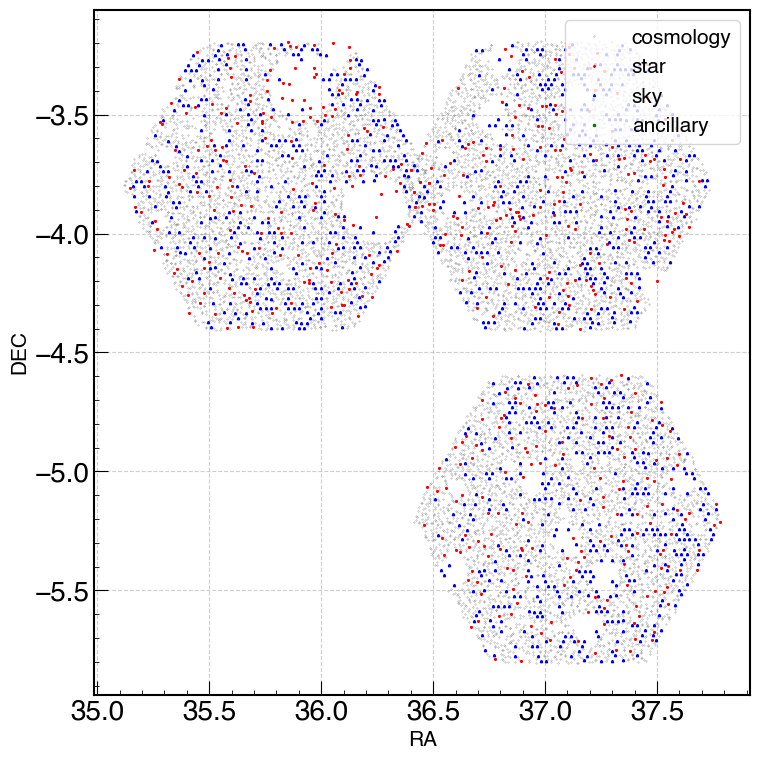

field b, L1, visit 1, cosmology 1576, star 186, sky 400
['ob_code', 'obj_id', 'ra', 'dec', 'exptime', 'priority', 'resolution', 'reference_arm', 'g_hsc', 'g_hsc_err', 'r2_hsc', 'r2_hsc_err', 'i2_hsc', 'i2_hsc_err', 'z_hsc', 'z_hsc_err', 'y_hsc', 'y_hsc_err', 'matched', 'catId', 'description']
['obj_id', 'ra', 'dec', 'exptime', 'stage', 'epoch', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'tract', 'patch', 'target_type_id', 'input_catalog_id', 'psf_mag_g', 'filter_g', 'psf_flux_g', 'psf_flux_error_g', 'filter_r', 'psf_flux_r', 'psf_flux_error_r', 'filter_i', 'psf_flux_i', 'psf_flux_error_i', 'filter_z', 'psf_flux_z', 'psf_flux_error_z', 'filter_y', 'psf_flux_y', 'psf_flux_error_y', 'filter_j', 'psf_flux_j', 'psf_flux_error_j', 'prob_f_star', 'teff_brutus', 'teff_brutus_low', 'teff_brutus_high', 'logg_brutus', 'logg_brutus_low', 'logg_brutus_high', 'teff_gspphot', 'teff_gspphot_lower', 'teff_gspphot_upper', 'is_fstar_gaia', 'version', 'catId', 'ob_code', '

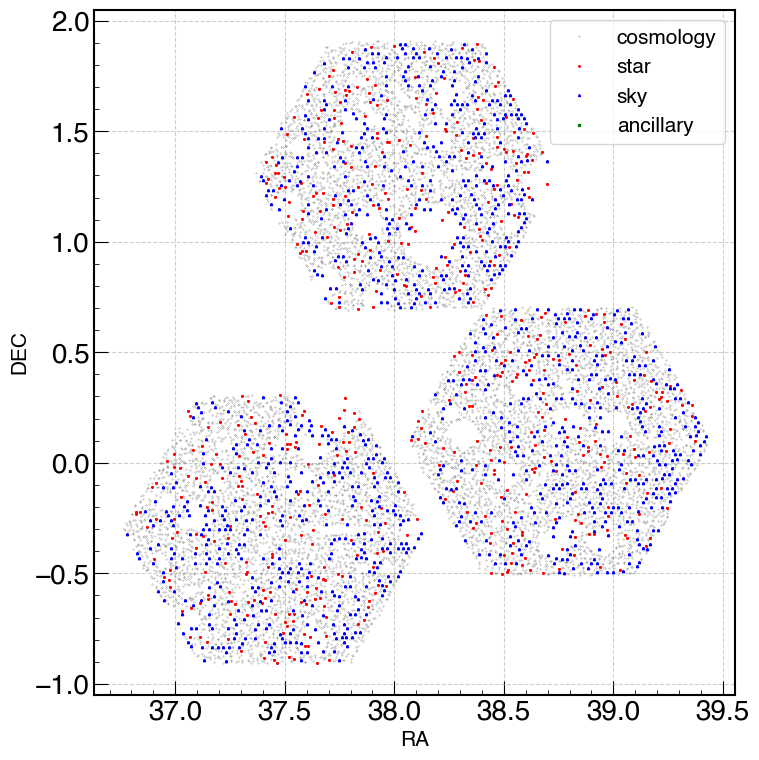

field e, L1, visit 1, cosmology 1567, star 200, sky 400
['ob_code', 'obj_id', 'ra', 'dec', 'exptime', 'priority', 'resolution', 'reference_arm', 'g_hsc', 'g_hsc_err', 'r2_hsc', 'r2_hsc_err', 'i2_hsc', 'i2_hsc_err', 'z_hsc', 'z_hsc_err', 'y_hsc', 'y_hsc_err', 'matched', 'catId', 'description']
['obj_id', 'ra', 'dec', 'exptime', 'stage', 'epoch', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'tract', 'patch', 'target_type_id', 'input_catalog_id', 'psf_mag_g', 'filter_g', 'psf_flux_g', 'psf_flux_error_g', 'filter_r', 'psf_flux_r', 'psf_flux_error_r', 'filter_i', 'psf_flux_i', 'psf_flux_error_i', 'filter_z', 'psf_flux_z', 'psf_flux_error_z', 'filter_y', 'psf_flux_y', 'psf_flux_error_y', 'filter_j', 'psf_flux_j', 'psf_flux_error_j', 'prob_f_star', 'teff_brutus', 'teff_brutus_low', 'teff_brutus_high', 'logg_brutus', 'logg_brutus_low', 'logg_brutus_high', 'teff_gspphot', 'teff_gspphot_lower', 'teff_gspphot_upper', 'is_fstar_gaia', 'version', 'catId', 'ob_code', '

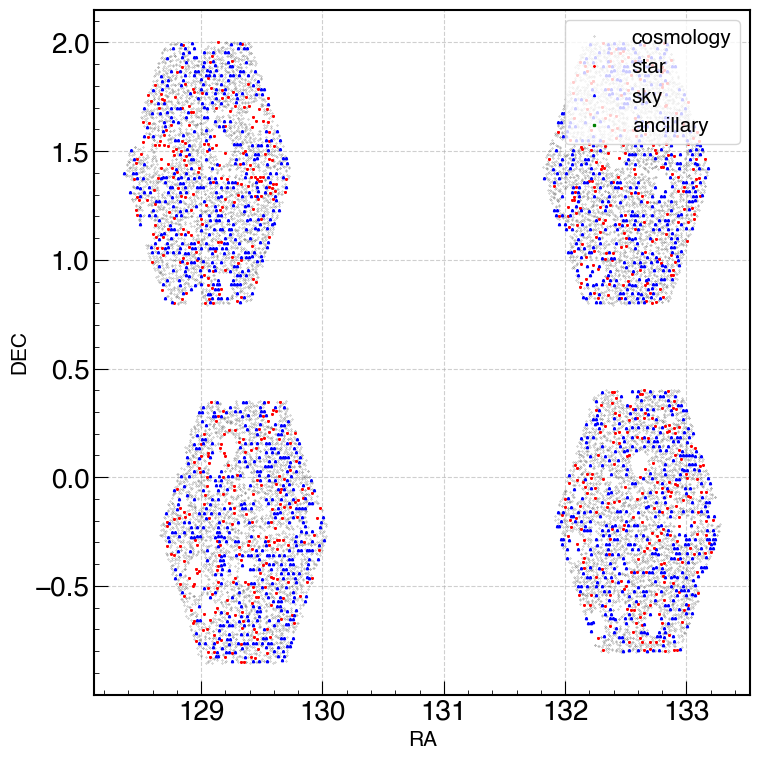

In [143]:
fdir_raw_Jan25 = '../data_raw/Jan25/'
prefix_org = 'cmx_01222025_DESI-ELG_'
outdir_Jan25 = '../output/Jan25/' 
fdir_proc_Jan25 = '../data_proc/Jan25/'

# HST(UTC-10) Jan 22 20:00 for field a and b, same for both visits, Jan 23 01:00 for field e
otime_list = ['2025-01-23T06:00:00Z', '2025-01-23T06:00:00Z', '2025-01-23T09:00:00Z']

for field, Li_list, otime in zip(['a', 'b', 'e'], [['L1', 'L3', 'L4'], ['L1', 'L2', 'L3'], ['L1', 'L2', 'L3', 'L4']], otime_list):
#for field, Li_list, otime in zip(['a', ], [['L1', 'L3', 'L4'], ], ['2025-01-23T06:00:00Z', ]):
    infn_list = [] # for each filed, including all Li and all visits
    # read original cosmology targets
    data_cos = ascii.read(fdir_raw_Jan25 + prefix_org + 'field-{}_v{}.csv'.format(field, 1))
    # read processed star targets
    data_star = ascii.read(fdir_proc_Jan25 + 'star_field_{}_targets.ecsv'.format(field))
    # read processed sky targets
    data_sky = ascii.read(fdir_proc_Jan25 + 'sky_field_{}_targets.ecsv'.format(field)) 

    # make 'epoch' of data_star to be 2016.
    data_star['epoch'] = np.zeros(len(data_star), dtype=np.float32) + 2016.

    # ob_code
    data_cos['ob_code'] = ['_Cos_'+str(x) for x in data_cos['obj_id']]
    data_star.add_column(data_star['ID'], name='ob_code')
    data_sky.add_column(data_sky['ID'], name='ob_code')

    # add catId to the cosmology targets with the value of 11 - HSC-SSP Public Data Release 4 (Wide)
    data_cos.add_column(np.ones(len(data_cos), dtype=np.int32) * 11, name='catId')
    data_cos.add_column(['HSC-SSP Public Data Release 4 (Wide)'] * len(data_cos), name='description')

    # add 'description' column to sky and star
    data_sky.add_column(['Sky positions from PS1'] * len(data_sky), name='description')
    data_star.add_column(['Fstar_v3.3'] * len(data_star), name='description')

    # change the 'catId' value of star and sky targets 
    data_sky['catId'] = np.zeros(len(data_sky), dtype=np.int32) + 2007
    data_star['catId'] = np.zeros(len(data_star) , dtype=np.int32) + 3006

    # rename 'ID', 'R.A.', 'Dec.' to 'obj_id', 'ra', 'dec' for the processed star and sky targets
    for old_name, new_name in zip(['ID', 'R.A.', 'Dec.', 'Exposure Time'], ['obj_id', 'ra', 'dec', 'exptime']):
        data_star.rename_column(old_name, new_name)
        data_sky.rename_column(old_name, new_name)

    # read netflow output
    for Li in Li_list:
        for visit in [1, 2]:
            infn = outdir_Jan25 + 'field_%s_%s_visit%d.txt'%(field, Li, visit)
            infn_list.append(infn)
        
            tgt_id_done = np.loadtxt(infn, usecols=(0, ), unpack=True, dtype='str')
            # match the tgt_id_done cosmology with the original cosmology targets
            obj_id_cos = np.array(['_Cos_'+str(x) for x in data_cos['obj_id']])
            mask_cos = np.in1d(obj_id_cos, tgt_id_done) 
            
            # match the tgt_id_done star with the processed star targets
            mask_star = np.in1d(data_star['obj_id'], tgt_id_done) 

            # match the tgt_id_done sky with the processed sky targets
            mask_sky = np.in1d(data_sky['obj_id'], tgt_id_done)
            
            print('field %s, %s, visit %d, cosmology %d, star %d, sky %d'%(field, Li, visit, np.sum(mask_cos), np.sum(mask_star), np.sum(mask_sky)))
            
            data_table = get_combined_table(field, Li, visit, data_cos[mask_cos], data_star[mask_star], data_sky[mask_sky])
            
            # write the final output to a file
            outfn = outdir_Jan25 + '/final/field_%s_%s_visit%d_final_targets.ecsv'%(field, Li, visit)
            data_table.write(outfn, format='ascii.ecsv', overwrite=True)
            print('write to %s'%outfn)
            
    figname = outdir_Jan25+'/final/fiberassign_'+field+'_done.png'
    plot_tgt_done(infn_list, figname, figsize=(8, 8), plot_diffcolor=True)

In [144]:
# read in data_table of field a, Li=L1, visit=1
data_table = ascii.read(outdir_Jan25 + '/final/field_a_L1_visit1_final_targets.ecsv')
print(data_table.colnames)
# check the data type of each column
for colname in data_table.colnames:
    print(colname, data_table[colname].dtype)
    


['ob_code', 'catId', 'description', 'ra', 'dec', 'exptime', 'priority', 'resolution', 'reference_arm', 'obj_id', 'g_hsc', 'g_hsc_err', 'epoch', 'input_catalog_id', 'psf_flux_g', 'g_ps1', 'g_ps1_error', 'r_ps1', 'r_ps1_error', 'i_ps1', 'i_ps1_error', 'z_ps1', 'z_ps1_error', 'y_ps1', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'target_type']
ob_code <U25
catId int32
description <U36
ra float64
dec float64
exptime float64
priority int32
resolution <U1
reference_arm <U1
obj_id int64
g_hsc float64
g_hsc_err float64
epoch float64
input_catalog_id float64
psf_flux_g float64
g_ps1 float64
g_ps1_error float64
r_ps1 float64
r_ps1_error float64
i_ps1 float64
i_ps1_error float64
z_ps1 float64
z_ps1_error float64
y_ps1 float64
parallax float64
parallax_error float64
pmra float64
pmra_error float64
pmdec float64
pmdec_error float64
target_type int32
